# pCO$_{2}$ Taylor Expansion
Conducting a Taylor Expansion of the impacts of DIC, Alk, SST, and SALT on pCO$_{2}$ during a climate variability event in EBUS. This is inspired from Nikki Lovenduski's 2007 and 2015 papers.

----

### Expansion

$ \Delta pCO_{2} = \frac{\partial pCO_{2}}{\partial DIC}\Delta DIC + \frac{\partial pCO_{2}}{\partial ALK}\Delta ALK + \frac{\partial pCO_{2}}{\partial SST}\Delta SST + \frac{\partial pCO_{2}}{\partial SALT}\Delta SALT $

### Sensitivity Terms

$ 	\frac{\partial pCO_{2}}{\partial SST} \approx 0.0423^{o}C^{-1}\cdot pCO_{2} $

$ 	\frac{\partial pCO_{2}}{\partial SALT} \approx \frac{pCO_{2}}{SALT} $

$ 	\frac{\partial pCO_{2}}{\partial DIC} = \frac{pCO_{2}}{DIC}\gamma_{DIC} $


$ 	\frac{\partial pCO_{2}}{\partial ALK} = \frac{pCO_{2}}{ALK}\gamma_{ALK} $


### Buffer Factors
$ \gamma_{DIC} = \frac{3\cdot ALK\cdot DIC - 2DIC^{2}}{(2DIC - ALK)(ALK - DIC)} $

$ \gamma_{ALK} = - \frac{ALK^{2}}{(2DIC - ALK)(ALK-DIC)} $


In [1]:
import glob
import numpy as np
from numpy import mean
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
ens = ['001', '002', '009', '010', '011',
       '012', '013', '014', '015', '016',
       '017', '018', '019', '020', '021',
       '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031',
       '032', '033', '034', '035', '101',
       '102', '103', '104', '105']
colors = {
    'CalCS': '#5ea46d',
    'HumCS': '#9173c8',
    'CanCS': '#b78f3b',
    'BenCS': '#cd5664'
}



# Functions

In [3]:
def load_forced_signal(VAR, EBU):
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    fileName = EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc'
    ds = xr.open_dataset(fileDir + fileName)
    data = ds[VAR + '_AW'].values
    return data

# Determine Sensitivity Terms

In [4]:
EBUs = ['CalCS', 'HumCS', 'CanCS', 'BenCS']
buffers = dict()
sensitivities = dict()
for idx in EBUs:
    pCO2 = load_forced_signal('pCO2SURF', idx)
    DIC = load_forced_signal('DIC', idx)
    SALT = load_forced_signal('SALT', idx)
    ALK = load_forced_signal('ALK', idx)
    SST = load_forced_signal('SST', idx)
    # Compute buffer factors for DIC/ALK.
    buffer_factor = dict()
    buffer_factor['ALK'] = -mean(ALK)**2 / ((2 * mean(DIC) - mean(ALK)) * (mean(ALK) - mean(DIC)))
    buffer_factor['DIC'] = (3*mean(ALK)*mean(DIC) - 2*mean(DIC)**2) / \
                           ((2 * mean(DIC) - mean(ALK)) * (mean(ALK) - mean(DIC)))
    # Compute sensitivities
    sensitivity = dict()
    sensitivity['SST'] = 0.0423 * mean(pCO2)
    sensitivity['SALT'] = mean(pCO2)/mean(SALT)
    sensitivity['ALK'] = (mean(pCO2)/mean(ALK))*buffer_factor['ALK']
    sensitivity['DIC'] = (mean(pCO2)/mean(DIC))*buffer_factor['DIC']
    # Place in final arrays.
    buffers[idx] = buffer_factor
    sensitivities[idx] = sensitivity

In [ ]:
# Make them Pandas!
buffers = pd.DataFrame(data=buffers)
sensitivities = pd.DataFrame(data=sensitivities)

In [ ]:
# Save for later!
directory = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/all-systems/'
buffers.to_csv(directory + 'pCO2_buffers_all_systems')
sensitivities.to_csv(directory + 'pCO2_sensitivities_all_systems')

# Compute Linear Expansion

In [5]:
def load_correlations(VAR, EBU, climvar, smoothed=True):
    fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/' + \
                EBU.lower() + '/region_correlations/'
    if smoothed == False:
        fileName = 'unsmoothed_' + VAR + '_vs_' + climvar + '_' + EBU
    else:
        fileName = 'smoothed_' + VAR + '_vs_smoothed_' + climvar + '_' + EBU        
    df = pd.DataFrame.from_csv(fileDir + fileName)
    df.index = ens
    return df

In [6]:
def taylor_expansion(EBU, climvar):
    pCO2_corr = load_correlations('pCO2SURF', EBU, climvar)
    DIC_corr = load_correlations('DIC', EBU, climvar)
    ALK_corr = load_correlations('ALK', EBU, climvar)
    SST_corr = load_correlations('SST', EBU, climvar)
    SALT_corr = load_correlations('SALT', EBU, climvar)
    # Drop where p-value is insignificant.
    conditions = (pCO2_corr['P-Value'] < 0.05) & (DIC_corr['P-Value'] < 0.05) & (ALK_corr['P-Value'] < 0.05) & \
        (SST_corr['P-Value'] < 0.05) & (SALT_corr['P-Value'] < 0.05)
    pCO2_corr = pCO2_corr.where(conditions).dropna()
    DIC_corr = DIC_corr.where(conditions).dropna()
    ALK_corr = ALK_corr.where(conditions).dropna()
    SST_corr = SST_corr.where(conditions).dropna()
    SALT_corr = SALT_corr.where(conditions).dropna()
    # Just pull out slopes.
    pCO2 = pCO2_corr['Slope']
    DIC = DIC_corr['Slope']
    ALK = ALK_corr['Slope']
    SST = SST_corr['Slope']
    SALT = SALT_corr['Slope']
    # Compute expansion and store as DataFrame.
    terms = dict()
    terms['DIC'] = DIC * sensitivities[EBU]['DIC']
    terms['ALK'] = ALK * sensitivities[EBU]['ALK']
    terms['SST'] = SST * sensitivities[EBU]['SST']
    terms['SALT'] = SALT * sensitivities[EBU]['SALT']
    terms = pd.DataFrame(data=terms)
    terms['Total'] = terms.sum(axis=1)
    return terms, conditions

In [7]:
def setup_dataframes(EBU, climvar):
    df, conditions = taylor_expansion(EBU, climvar)
    df = pd.melt(df)
    df['EBUS'] = EBU
    return df, conditions

# Run Computations

In [25]:
# Load in sensitivity/buffer results.
fileDir = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/all-systems/'
buffers = pd.DataFrame.from_csv(fileDir + 'pCO2_buffers_all_systems')
sensitivities = pd.DataFrame.from_csv(fileDir + 'pCO2_sensitivities_all_systems')

In [26]:
climvar = 'amo'
df_cal, calConditions = setup_dataframes('CalCS', climvar)
df_hum, humConditions = setup_dataframes('HumCS', climvar)
df_can, canConditions = setup_dataframes('CanCS', climvar)
df_ben, benConditions = setup_dataframes('BenCS', climvar)
frames = [df_cal, df_hum, df_can, df_ben]
taylor_terms = pd.concat(frames)

# Compare Approximation to Model Regression

In [30]:
EBU = "BenCS"
climvar = "amo"
if EBU == 'CalCS':
    df = df_cal.copy()
    conditions = calConditions
elif EBU == 'HumCS':
    df = df_hum.copy()
    conditions = humConditions
elif EBU == 'CanCS':
    df = df_can.copy()
    conditions = canConditions
elif EBU == 'BenCS':
    df = df_ben.copy()
    conditions = benConditions
###
directory = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/data/processed/' + EBU.lower() + \
    '/region_correlations/'
model_regression = pd.DataFrame.from_csv(directory + 'smoothed_pCO2SURF_vs_smoothed_' + climvar + '_' + EBU)
model_regression.index = ens
model_regression = model_regression.where(conditions).dropna()
###
print EBU + "/" + climvar.upper() + " Decomposition"
print '-------'
print('Model Regression: {}').format(np.mean(model_regression['Slope']))
print('Taylor Expansion: {}').format(np.mean(df[df['variable']=='Total']).value)

BenCS/AMO Decomposition
-------
Model Regression: 0.0169944058548
Taylor Expansion: -0.246440544368


# Visualize

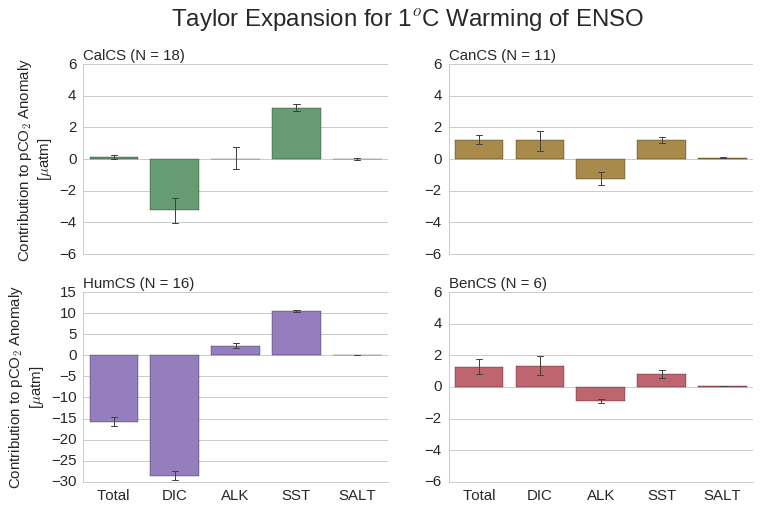

In [11]:
EBUs = ['CalCS', 'CanCS', 'HumCS', 'BenCS']
frames = [df_cal, df_can, df_hum, df_ben]
order = list(['Total', 'DIC', 'ALK', 'SST', 'SALT'])
sns.set_style('whitegrid')
fig = plt.figure(figsize=(12,8))
if climvar == "enso" or climvar=="amo":
    st = fig.suptitle('Taylor Expansion for 1$^{o}$C Warming of ' + climvar.upper(), fontsize=24)
else:
    st = fig.suptitle('Taylor Expansion for 1$\sigma$ of ' + climvar.upper(), fontsize=24)
for i, EBU in enumerate(EBUs):
    ax = fig.add_subplot(2, 2, i+1)
    bars = sns.barplot(x='variable', y='value', data=frames[i], ax=ax, 
               ci=95, capsize=0.1, errwidth=1, color=colors[EBU], order=order)
    # Only label x axis on bottom
    if i == 0 or i == 1:
        bars.set_xticklabels('')
    if i == 0 or i == 2:
        bars.set_ylabel('Contribution to pCO$_{2}$ Anomaly' + '\n' + '[$\mu$atm]',
                        fontsize=15)
    else:
        bars.set_ylabel('')
    bars.set_xlabel('')
    bars.tick_params(axis='both', which='major', labelsize=15)
    # Annotate to tell EBUS
    bars.set_title(EBU + ' (N = ' + str(len(frames[i][frames[i]['variable']=='ALK'])) + ')', loc='left', fontsize=15)
    # + + + SET Y LIMS FOR EQUAL COMPARISON
    if climvar == "enso" and i != 2:
        bars.set_ylim([-6, 6])
    elif climvar == "pdo":
        bars.set_ylim([-14, 8])
    elif climvar == "amo":
        bars.set_ylim([-50, 80])
    elif climvar == "sam":
        bars.set_ylim([-15, 30])
    
#fig.tight_layout()
fig.subplots_adjust(top=0.85)
st.set_y(0.95)
sns.despine()
#plt.savefig('/glade/u/home/rbrady/projects/EBUS_BGC_Variability/reports/figs/all-systems/' + \
#           'taylor_expansions/taylor-expansion-' + climvar.upper() + '-pCO2-PVALUEREMOVED-smoothedClimate.png', dpi=300)

# Brute Force Visualize True Totals for ICDC Poster
- Will fix this later. Just creating an array of delta pCO2 'true' values from the compare approximation vs. true total cell

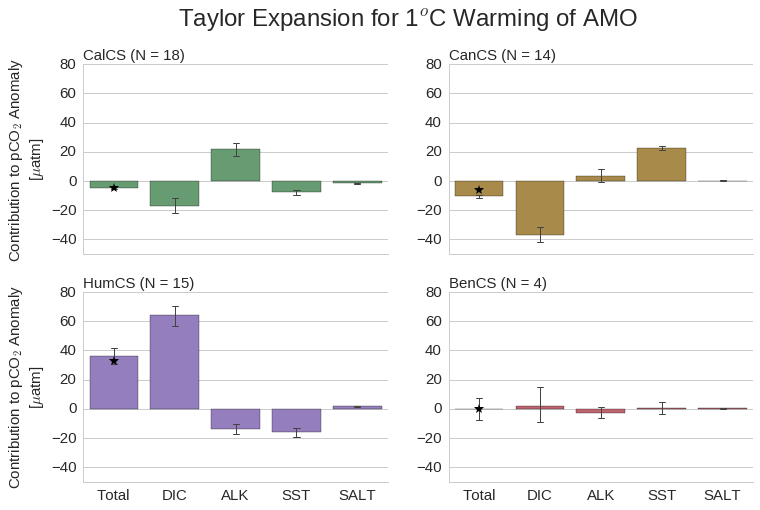

In [32]:
TOTALS = [-4.95, -5.95, 32.60, 0.02]
EBUs = ['CalCS', 'CanCS', 'HumCS', 'BenCS']
frames = [df_cal, df_can, df_hum, df_ben]
order = list(['Total', 'DIC', 'ALK', 'SST', 'SALT'])
sns.set_style('whitegrid')
fig = plt.figure(figsize=(12,8))
if climvar == "enso" or climvar=="amo":
    st = fig.suptitle('Taylor Expansion for 1$^{o}$C Warming of ' + climvar.upper(), fontsize=24)
else:
    st = fig.suptitle('Taylor Expansion for 1$\sigma$ of ' + climvar.upper(), fontsize=24)
for i, EBU in enumerate(EBUs):
    ax = fig.add_subplot(2, 2, i+1)
    bars = sns.barplot(x='variable', y='value', data=frames[i], ax=ax, 
               ci=95, capsize=0.1, errwidth=1, color=colors[EBU], order=order)
    # Plot total from delta pCO2 regression
    plt.plot(0, TOTALS[i], '*k', markersize=10)
    # Only label x axis on bottom
    if i == 0 or i == 1:
        bars.set_xticklabels('')
    if i == 0 or i == 2:
        bars.set_ylabel('Contribution to pCO$_{2}$ Anomaly' + '\n' + '[$\mu$atm]',
                        fontsize=15)
    else:
        bars.set_ylabel('')
    bars.set_xlabel('')
    bars.tick_params(axis='both', which='major', labelsize=15)
    # Annotate to tell EBUS
    bars.set_title(EBU + ' (N = ' + str(len(frames[i][frames[i]['variable']=='ALK'])) + ')', loc='left', fontsize=15)
    # + + + SET Y LIMS FOR EQUAL COMPARISON
    if climvar == "enso" and i != 2:
        bars.set_ylim([-6, 6])
    elif climvar == "pdo":
        bars.set_ylim([-14, 8])
    elif climvar == "amo":
        bars.set_ylim([-50, 80])
    elif climvar == "sam":
        bars.set_ylim([-15, 30])
    
#fig.tight_layout()
fig.subplots_adjust(top=0.85)
st.set_y(0.95)
sns.despine()
plt.savefig('/glade/u/home/rbrady/projects/EBUS_BGC_Variability/reports/figs/all-systems/' + \
           'taylor_expansions/taylor-expansion-' + climvar.upper() + '-pCO2-PVALUEREMOVED-smoothedClimate.eps', 
            transparent=True, format='eps', bbox_inches='tight', pad_inches=1, dpi=1000)